In [1]:
import msprime, tskit
import matplotlib.pyplot as plt # Only needed for plotting
import numpy as np
import pandas as pd
from IPython.display import SVG
from matplotlib.patches import Polygon

# Analyses with tskit

At the end of the previous worksheet, we looked at ways to convert the mutation information in tree sequences back out into sequence information so we could calculate various cool statistics with it. 

However, it turns out you don't need to do this a lot of the time.
There's a lot you can do within tskit, and these native methods are often quicker and more efficient than these other methods.

Firsst, we'll simulate a tree sequence dataset with mutations to use in the rest of this notebook.
Here's a simple 3-population model, where the 2 pops split 50 generations ago from an ancestral population, and the third is formed after an admixture event between these two. One of these modern-day unadmixed pops is smaller than the other. 

In [2]:
demography = msprime.Demography()
demography.add_population(name="SMALL", initial_size=200)
demography.add_population(name="BIG", initial_size=500)
demography.add_population(name="ADMIX", initial_size=200)
demography.add_population(name="ANC", initial_size=500)
demography.add_admixture(
    time=20, derived="ADMIX", ancestral=["SMALL", "BIG"], proportions=[0.5, 0.5])
demography.add_population_split(time=600, derived=["SMALL", "BIG"], ancestral="ANC")
# demography.debug()

PopulationSplit(time=600, derived=['SMALL', 'BIG'], ancestral='ANC')

In [3]:
ts = msprime.sim_ancestry(samples={"SMALL": 10, "BIG": 10, "ADMIX" : 10},
                          demography=demography, random_seed=2432,
                         sequence_length=5e7, recombination_rate=1e-8)
ts = msprime.sim_mutations(ts, rate=1e-8, random_seed=6151)
ts

In [4]:
tss = ts.simplify(samples=[1, 11, 21, 31, 41, 51])
mts1 = msprime.sim_mutations(tss, rate=1e-8, random_seed=1812)
mts2 = msprime.sim_mutations(tss, rate=1e-8, random_seed=1901)

## Tree stats

Suppose you wanted to calculate something like mean pairwise diversity with some sequence data of $n$ samples.
Here's an equation you can use:

$$ \pi = \dfrac{1}{n(n-1)/2}\sum_{i=1}^{n-1} \sum_{j=i+1}^n k_{ij} $$

where $k_{ij}$ is the number of sites where sequences $i$ and $j$ have a different allele. (Got this from Matt Hahn's MolPopGen book.)

First you look at the first two alleles -- are they the same or different? Update the statistic, move to the next position. Are they the same or different? update the statistic, move on. Do this for every site in the sample, to get some number. Then you have to do this again for every possible pair of sequences -- the calculation is (n choose 2) * M, where n is the number of samples, and M the number of sites. The scaling is

$$ O\left( n^2 m \right) $$

where $m$ is the number of sites.


Howver, because these sequences are simply a projection onto the present day of *mutations* on a tree sequence, and these mutations only appear once, there should be ways of updating all statistics every time you come across a mutation on a given branch. (Probably don’t need quite this much explanation). This is basically what tree sequences statistics offer.

See this paper:

Peter Ralph, Kevin Thornton, Jerome Kelleher, Efficiently Summarizing Relationships in Large Samples: A General Duality Between Statistics of Genealogies and Genomes, Genetics, Volume 215, Issue 3, 1 July 2020, Pages 779–797, https://doi.org/10.1534/genetics.120.303253

### Nucleotide diversity: an example of the basic syntax

Tree sequence statistics are methods that you can perform on tree sequence objects:


In [5]:
%%time
ts.diversity()

CPU times: user 4.22 ms, sys: 66 µs, total: 4.28 ms
Wall time: 4.26 ms


array(2.33554011e-05)

Note it's a lot faster than the previous example, even though it's also bigger (more mutations, and more samples).
A quick note: by default, `tskit` will present a normalised version of this statistic scaled by the length of the region represented in `ts`. (This allows you to make comparisons between different tree sequences that may be of different lengths). However, this isn't how all other software computes diversity.
If you wish to disable this behaviour, use the `span_normalise` argument

In [6]:
div = ts.diversity(span_normalise=False)
div[()]

1167.7700564971785

What else might you want to do? Well, remember our dataset consists of samples from two populations here, of different sizes. We’d expect them to each have different diversity levels, and for these to differ from the overall (sample-wide) diversity rate. We can get this information out by specifying each of these with the `sample_nodes` output.

In [7]:
ts.tables.populations

id,metadata
0,"{'description': '', 'name': 'SMALL'}"
1,"{'description': '', 'name': 'BIG'}"
2,"{'description': '', 'name': 'ADMIX'}"
3,"{'description': '', 'name': 'ANC'}"


In [8]:
ts.samples(3)

array([], dtype=int32)

In [9]:
samples_of_interest=[ts.samples(population=0),
                          ts.samples(population=1),
                          ts.samples(population=2),
                          ts.samples()]
ts.diversity(sample_sets=samples_of_interest)

array([1.16266316e-05, 2.02216842e-05, 2.15248421e-05, 2.33554011e-05])

In [10]:
ts.diversity(sample_sets=[[12, 14, 18, 7, 8],
                          [23, 19, 10]])

array([1.11880000e-05, 2.55733333e-05])

#### Genome scans

So far — we’ve just been calculating these values along the entire regions. However, in many cases, you might be more interested in a scan of these values, to see how they vary along the genome. You can do this with the `windows` argument. You specify the start and end points of the sequence, and the locations of the breakpoints between each window. For instance, here, we’re specifying some windows of length 100kb:

In [11]:
breakpoints = [i*1e6 for i in range(0, 50 + 1)]
print(breakpoints)

[0.0, 1000000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0, 10000000.0, 11000000.0, 12000000.0, 13000000.0, 14000000.0, 15000000.0, 16000000.0, 17000000.0, 18000000.0, 19000000.0, 20000000.0, 21000000.0, 22000000.0, 23000000.0, 24000000.0, 25000000.0, 26000000.0, 27000000.0, 28000000.0, 29000000.0, 30000000.0, 31000000.0, 32000000.0, 33000000.0, 34000000.0, 35000000.0, 36000000.0, 37000000.0, 38000000.0, 39000000.0, 40000000.0, 41000000.0, 42000000.0, 43000000.0, 44000000.0, 45000000.0, 46000000.0, 47000000.0, 48000000.0, 49000000.0, 50000000.0]


In [12]:
div = ts.diversity(sample_sets=samples_of_interest, windows=breakpoints)
print(div.shape)
# print(div)

(50, 4)


The result is now that we get a 50 by 4 array, one row for each window, each element of the row being diversity value in that particular window amongst a particular set of samples. Let’s plot these:

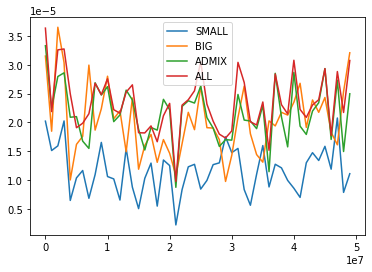

In [13]:
names_to_plot = ['SMALL', 'BIG', 'ADMIX', 'ALL']
lines = plt.plot(breakpoints[:-1], div)
plt.legend(lines, names_to_plot);

Because we ran a neutral simulation, we don’t expect any significant changes in diversity along the genome, and the variation we do see is likely just noise. Soon, we’ll see another way to clarify this. 

### Multi-way statistics

So far we’ve been looking only at diversity, to help us get used to the general syntax of tskit’s statistics interface. But there are many others which work in exactly the same way. The only thing that can really differ is whether the statistics are 'one-way' or 'not.

Diversity is an example of a 'one-way' statistic. Basically, this means that the statistic is based on calculating a number where all of the samples are exchangeable in the calculation: if you were to re-label one of the samples with another label, you’d still get the same number out, all of the samples have the exact same 'role' in the calculation you perform.

Other examples of one-way statistics are: (list them) in these, you can specify any number of 'sample_sets' and the one-way statitic will be computed on each of them in turn.

 - [allele_frequency_spectrum](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.allele_frequency_spectrum)
 - [segregating_sites](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.segregating_sites)
 - [Tajimas_D](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.Tajimas_D)
 - [trait_covariance](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.trait_covariance), [trait_correlation](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.trait_correlation) and [trait_linear_model](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.trait_linear_model)
 
These last 3 are interesting ones we'll look at later link [here](https://tskit.dev/tskit/docs/stable/stats.html#sec-stats-notes-trait). 

This is *not* the case for certain other population genetic statistics that we call ‘multi-way statistics’. F-statistics being a prime example.
F3: a measure of ‘admixedness’. You can’t just put some samples from A in B, or from B in C, you’ll get a completely different number (that will often not represent the thing you are actually trying to measure).
In these statistics, you’ll need to pay special heed to the `sample_sets` argument — the docs will specify exactly how many sets are required, and what should be in which field, to get the statistic you are interested in. For F3, we need (a, b, c)

In [14]:
f3_012 = ts.f3(sample_sets=[ts.samples(0), ts.samples(1), ts.samples(2)],
               windows=breakpoints)
f3_102 = ts.f3(sample_sets=[ts.samples(1), ts.samples(0), ts.samples(2)],
               windows=breakpoints)
f3_201 = ts.f3(sample_sets=[ts.samples(2), ts.samples(0), ts.samples(1)],
               windows=breakpoints)

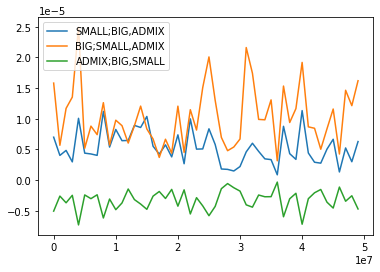

In [15]:
names_to_plot = ['SMALL;BIG,ADMIX', 'BIG;SMALL,ADMIX', 'ADMIX;BIG,SMALL']
lines = plt.plot(breakpoints[:-1], np.transpose([f3_012, f3_102, f3_201]))
plt.legend(lines, names_to_plot)

The green line `f3(ADMIX;BIG,SMALL)` is different to the others, consistently below 0. This suggests that `ADMIX` might be an admixed population with gene flow from `BIG` and `SMALL` (which is indeed the case, since this is what we simulated).

Here are some other examples of multi-way statistics provided by tskit: (add in links later)

 - divergence
 - genetic_relatedness
 - Patterson's f2, f3, f4
 - genealogical_nearest_neighbours
 - Fst

### Branch stats

We saw, and briefly noted, how apparently the statistics were along the genome. As you know by now, some of this is just noise, and it can be difficult doing this statistic test by just eyeballing the data. A big part of many population genetic tests, including tests for selection, introgressed regions, is being able to make educated guesses about where the patterns you see are *not* due to this.
This is complicated by the fact that there are several different types of randomness in genetic models that interact with each other.
There is randomness in the genealogical trees that are produced. If you have two populations same in size, still may have coalescences (common ancestors) in slightly different times (expect those to obey the same distribution), each simulation is just one realisation of potential history, and randomness of recombination means locations, lengths along which those relationships hold also random (this is what sim_ancestry models).

On top of that, there’s added randomness due to randomness of mutation processes. Even if you have two regions of a genome in a given individual that has been inherited from the same two regions of some ancestor, inherited via the same set of genealogical descendants, there may be a different density of mutations simply because of the randomness of mutations.

Consider how different one of our trees looks...

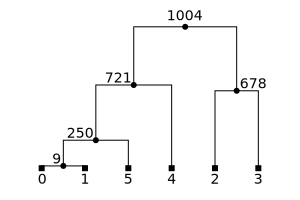

In [16]:
# [Look at two different trees that are very far apart from each other]
sts = ts.simplify(samples=[1, 11, 21, 31, 41, 51])
tree = sts.first()
display(SVG(tree.draw(width=300)))

from one much further along the genome

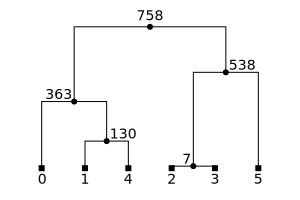

In [17]:
tree = sts.last()
display(SVG(tree.draw(width=300)))

When you calculate statistics based on allele-frequencies — what we call site-based statistics — *both* of these sources of noise contribute to the noisiness you see.

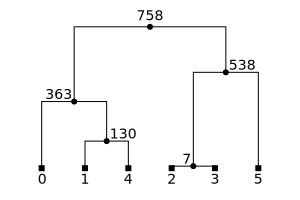

In [18]:
# [Look at the same tree, overlaid with different mutations each time]
display(SVG(mts1.last().draw(width=300)))

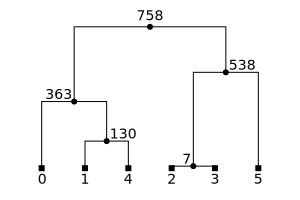

In [19]:
display(SVG(mts2.last().draw(width=300)))

But in tree sequences, you have information about branches which allows you to bypass this latter type of mutation.
Instead of moving up the trees and updating counts of some statistic every time you come across a mutation, update the statistic based on the *number of mutations you expect*. This is proportional to the branch length (since we’re assuming uniformity of mutations over time). This is the basic idea of branch stats — low variance form of site-based statistic that substitutes the length of each branch for the actual number of mutations on that branch. Note this deals with the second type of randomness, so is overall lower variance.

Here are the diversity stats we looked at before, this time with the branch versions included. Notice that the branch and site versions are clearly correlated, which makes sense — the mutations on a given tree are conditional on that tree — but the branch versions have significantly lower variance.

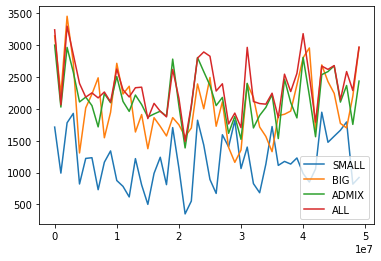

In [20]:
# [Diversity stat]
div = ts.diversity(sample_sets=samples_of_interest, windows=breakpoints, mode='branch',span_normalise=True)
names_to_plot = ['SMALL', 'BIG', 'ADMIX', 'ALL']
lines = plt.plot(breakpoints[:-1], div)
plt.legend(lines, names_to_plot);

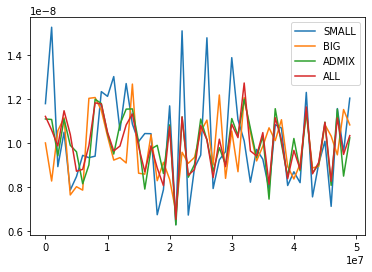

In [21]:
# [Diversity stat]
breakpoints = [i*1e6 for i in range(0, 50 + 1)]
div_site = ts.diversity(sample_sets=samples_of_interest, windows=breakpoints, mode='site')
div_branch = ts.diversity(sample_sets=samples_of_interest, windows=breakpoints, mode='branch')
names_to_plot = ['SMALL', 'BIG', 'ADMIX', 'ALL']
# lines = plt.plot(breakpoints[:-1], div_site)
lines = plt.plot(breakpoints[:-1], div_site/div_branch)
plt.legend(lines, names_to_plot);

Since publication, has been leveraged in other more specific applications (Charleston Chiang, genetic_relatedness, our work). May be that conditional on having accurate tree , simulated or otherwise, departures between the branch and site versions of a statistic may indicate other processes of interest — mutagens affected particular genomic regions, for instance.

(Is there some way to scale according to the mutation rate?)

## Simplify

Simplify is a powerful and flexible subsetting operation on tree sequences. 
Simplify your tree sequence so that it shows only the information you need (and correspondingly, easier
Two of the most common ’subsetting’ operations we want to do with genomic datasets: We want to 
-  Look at the data for a subset of the samples in the original dataset
- Look at sequence/variant information at only the sites that vary with respect to that subset.
You’ve probably used bcftoolls, vcftools to do some combo of these things before if you’ve worked with real data.
Tree sequence version of that is simplify, but it does a lot more. 

Basic syntax: the ’simplify’ method, with a list of sample IDs that you want to be in the new tree sequence.
Here, we return the tree sequence for all of the admixed samples (which remember, has a population label of ‘2’):

In [22]:
tss = ts.simplify(ts.samples(2))
tss

In [23]:
ts

Examining this, we have a smaller tree sequence. Now 20 samples — just those that were in this population in the bigger tree seq. Also fewer edges, nodes in general — means statistics and other analyses will run quicker that if you’d used [sample_sets] in the bigger one.

Note that the number of sites and mutations is also reduced. This is because simplify, in removing all the bits of ’tree sequence’ that weren’t necessary for the genealogy of these samples, it’s also removed all the mutations on those branches. These will either be mutations that are only inherited by other samples, or mutation that are ancestral to everyone in this smaller subset (so not variant sites).

Also also -- it's not too much smaller. (not by 1/3, which is what you'd expect if tree sequences scaled linearly)

Turns out that being able to do this operation efficiently is essential to using tree sequences in forward-time simulations — see [simplify paper] if interested.

## local ancestry

Simulate with a census event

In [24]:
demography = msprime.Demography()
demography.add_population(name="SMALL", initial_size=200)
demography.add_population(name="BIG", initial_size=500)
demography.add_population(name="ADMIX", initial_size=200)
demography.add_population(name="ANC", initial_size=500)
demography.add_admixture(
    time=20, derived="ADMIX", ancestral=["SMALL", "BIG"], proportions=[0.5, 0.5])
demography.add_census(time=21)
demography.add_population_split(time=600, derived=["SMALL", "BIG"], ancestral="ANC")
# demography.debug()

PopulationSplit(time=600, derived=['SMALL', 'BIG'], ancestral='ANC')

In [25]:
ts = msprime.sim_ancestry(samples={"SMALL": 10, "BIG": 10, "ADMIX" : 10},
                          demography=demography, random_seed=1001,
                         sequence_length=5e7, recombination_rate=1e-8)
ts

Get census nodes

In [26]:
census_nodes = []
for n in ts.nodes():
    if n.time == 21:
        census_nodes.append(n.id)

Apply link-ancestors

In [27]:
local_ancestry = ts.tables.link_ancestors(samples=[40,41], ancestors=census_nodes)

In [28]:
local_ancestry

id,left,right,parent,child,metadata
0,36346020.00000000,36729099.00000000,228,40,b''
1,37607517.00000000,38180194.00000000,235,41,b''
2,38180194.00000000,44484003.00000000,236,41,b''
3,44484003.00000000,45771986.00000000,237,41,b''
4,45771986.00000000,45898358.00000000,238,41,b''
5,39225748.00000000,39623302.00000000,243,40,b''
6,39623302.00000000,39659028.00000000,244,40,b''
7,26237653.00000000,33436160.00000000,303,41,b''
8,7357071.00000000,9589874.00000000,345,41,b''
9,9589874.00000000,12614062.00000000,346,41,b''


Note that every number in the 'parent' table above is one of the nodes in `ancestors_1000_gens`. This is essentially what `link_ancestors` does -- it shows you directly which of your samples descend from which ancestors.

3. Replace the parent nodes with their population label

In [29]:
def get_population_id(node, ts):
    return ts.tables.nodes.population[node]

In [30]:
ancestry_table = pd.DataFrame(
    data = {
        'left': local_ancestry.left,
        'right': local_ancestry.right,
        'population' : [get_population_id(u, ts) for u in local_ancestry.parent],
        'child' : local_ancestry.child
    }
)

print(ancestry_table)

          left       right  population  child
0   36346020.0  36729099.0           0     40
1   37607517.0  38180194.0           0     41
2   38180194.0  44484003.0           0     41
3   44484003.0  45771986.0           0     41
4   45771986.0  45898358.0           0     41
5   39225748.0  39623302.0           0     40
6   39623302.0  39659028.0           0     40
7   26237653.0  33436160.0           0     41
8    7357071.0   9589874.0           0     41
9    9589874.0  12614062.0           0     41
10  12614062.0  12854207.0           0     41
11  12854207.0  15399352.0           0     41
12   5940591.0   7357071.0           0     41
13  43118654.0  43804990.0           0     40
14  45898358.0  50000000.0           0     41
15  43804990.0  49258474.0           0     40
16  49258474.0  50000000.0           0     40
17  34354004.0  36346020.0           0     40
18  15399352.0  21523924.0           0     41
19  36729099.0  38492586.0           0     40
20  38492586.0  39225748.0        

If you want: sort, and squash

In [31]:
ancestry_table.sort_values(by=['child','left'], inplace=True, ignore_index=True)

ancestry_table

,left,right,population,child
0,0.0,1408063.0,1,40
1,1408063.0,1698837.0,1,40
2,1698837.0,2265254.0,1,40
3,2265254.0,2450811.0,0,40
4,2450811.0,2787682.0,1,40
5,2787682.0,4064949.0,1,40
6,4064949.0,23036036.0,1,40
7,23036036.0,24061124.0,1,40
8,24061124.0,26864266.0,1,40
9,26864266.0,32782918.0,1,40


In [32]:
new_sample = []
new_left = []
new_right = []
new_population = []

for ind, row in ancestry_table.iterrows():
    if ind > 0 and row['left']==new_right[-1] and row['population'] == new_population[-1] and row['child'] == new_sample[-1]:
        new_right[-1] = row['right']
    else:
        new_sample.append(row['child'])
        new_left.append(row['left'])
        new_right.append(row['right'])
        new_population.append(row['population'])
        
squashed_ancestry_table = pd.DataFrame({
    'child': [int(i) for i in new_sample],
    'left' : new_left,
    'right': new_right,
    'population' : [int(p) for p in new_population]
})

squashed_ancestry_table

,child,left,right,population
0,40,0.0,2265254.0,1
1,40,2265254.0,2450811.0,0
2,40,2450811.0,34354004.0,1
3,40,34354004.0,39659028.0,0
4,40,39659028.0,43118654.0,1
5,40,43118654.0,50000000.0,0
6,41,0.0,5940591.0,1
7,41,5940591.0,21523924.0,0
8,41,21523924.0,26237653.0,1
9,41,26237653.0,50000000.0,0


In [ ]:
# def plot_ancestry_chunk(row, chrom):
#     l = row.left*1e-6
#     r = row.right*1e-6
#     p = row.population
#     if int(p) == 0:
#         c = 'blue'
#     elif int(p) == 1:
#         c = 'red'
#     print('p is', p)
#     chunk = np.array([[l, 0], [r, 0], [r, 1], [l, 1]])
#     chrom.add_patch(Polygon(xy=chunk, color = c))

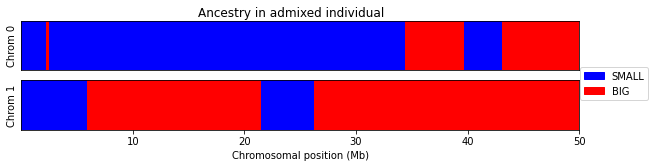

In [39]:
chrom_labels = {40: 'chr0', 41: 'chr1'}
colors = ['red', 'blue']
length = ts.sequence_length

fig, (chr0, chr1) = plt.subplots(2, figsize=(10,2))
fig.suptitle('Ancestry in admixed individual')
fig.frameon=False
fig.legend(
    handles = [Polygon(xy = np.array([[0,0],[0,1],[1,1],[1,0]]), color = 'blue'),
              Polygon(xy = np.array([[0,0],[0,1],[1,1],[1,0]]), color = 'red')],
    labels = ['SMALL', 'BIG'],
    loc = 'right'
)
for ind, row in squashed_ancestry_table.iterrows():
    chunk = np.array([[row.left/length, 0], [row.right/length, 0],
                      [row.right/length, 1], [row.left/length, 1]])
    if chrom_labels[row.child] == 'chr0':
        chr0.add_patch(Polygon(xy=chunk, color = colors[int(row.population)]))
    elif chrom_labels[row.child] == 'chr1':
        chr1.add_patch(Polygon(xy=chunk, color = colors[int(row.population)]))

chr0.set_ylabel('Chrom 0')
chr0.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
chr1.set_xticks(ticks= [0.2, 0.4, 0.6, 0.8, 1.0], labels=[10, 20, 30, 40, 50])
chr1.set_xlabel('Chromosomal position (Mb)')
chr1.set_ylabel('Chrom 1')
chr1.tick_params(left=False, labelleft=False)
    

## ibd-segments

In [57]:
ibd_info = ts.ibd_segments()
print(ibd_info)

╔════════════════════════════╗
║IdentitySegments            ║
╠══════════════╤═════════════╣
║Parameters:   │             ║
║max_time      │          inf║
║min_span      │            0║
║store_pairs   │        False║
║store_segments│        False║
║Results:      │             ║
║num_segments  │      3582984║
║total_span    │88500000000.0║
╚══════════════╧═════════════╝



In [41]:
ibd_info = ts.ibd_segments(
    within = [1, 2, 3, 4],
    store_segments=True
)
print(ibd_info)

╔══════════════════════════╗
║IdentitySegments          ║
╠══════════════╤═══════════╣
║Parameters:   │           ║
║max_time      │        inf║
║min_span      │          0║
║store_pairs   │      False║
║store_segments│       True║
║Results:      │           ║
║num_segments  │       4998║
║total_span    │300000000.0║
╚══════════════╧═══════════╝



In [43]:
# def print_ibd(find_ibd_output):
#     for key in find_ibd_output.keys():
#         print('Common ancestral segments for sample pair', key, ':')
#         ibd = find_ibd_output[key]
#         for i in range(len(ibd.left)):
#             print('Interval: [', ibd.left[i], ibd.right[i], '),', 
#                  'ancestral node:', ibd.node[i])
#         print()
        
# print_ibd(ibd_info)

In [45]:
# ibd_info = ts.ibd_segments(
#     between = [[1, 2], [3, 4]],
#     store_segments=True
# )

# print_ibd(ibd_info)

In [50]:
ibd_info = ts.ibd_segments(
    within = [1, 2, 3, 4],
    min_span = 2e6,
    store_segments=True
)
print_ibd(ibd_info)

Common ancestral segments for sample pair (1, 3) :
Interval: [ 19364337.0 23294773.0 ), ancestral node: 979
Interval: [ 24834138.0 30357623.0 ), ancestral node: 979

Common ancestral segments for sample pair (1, 4) :
Interval: [ 31553052.0 33887652.0 ), ancestral node: 163

Common ancestral segments for sample pair (2, 3) :
Interval: [ 41591115.0 50000000.0 ), ancestral node: 168

Common ancestral segments for sample pair (2, 4) :
Interval: [ 25822034.0 30369674.0 ), ancestral node: 1034



In [55]:
ibd_info = ts.ibd_segments(
    within = [0, 1, 2, 3],
    max_time = 20,
    store_segments=True
)
print_ibd(ibd_info)

Common ancestral segments for sample pair (0, 2) :
Interval: [ 1949245.0 4915106.0 ), ancestral node: 177

Common ancestral segments for sample pair (0, 3) :
Interval: [ 9815119.0 10765754.0 ), ancestral node: 181

Common ancestral segments for sample pair (2, 3) :
Interval: [ 41591115.0 50000000.0 ), ancestral node: 168



Here's an IBD version of the plot we made before: